In [78]:
# Import python modules

import pandas as pd
import numpy as np
import glob
import datetime
from datetime import timedelta, datetime, date
import requests
import os
import json
from pandas.io.json import json_normalize
import seaborn as sns
from dotenv import load_dotenv
load_dotenv()

import coinbasepro as cbp
from coinbase.wallet.client import Client

%matplotlib inline

In [79]:
# Read API key from .env file

cb_public_key = os.getenv("CB_PUBLIC_KEY")
cb_secret_key = os.getenv("CB_SECRET_KEY")
client = Client(cb_public_key, cb_secret_key, api_version='YYYY-MM-DD')

In [80]:
# Format date from existing ISO8601 format in CoinbasePro API using datetime function strptime formatter and conduct timeframe calculation using timedelta to obtain data for 365 days. Set start date and use timedelta to add and subtruct number of days to get data for desired timeframe.

startDate = "2020-01-05T12:00:00"
start = datetime.strptime(startDate, '%Y-%m-%dT%H:%M:%S')

finalDate1 = start + timedelta(299)
finalDate2 = start - timedelta(67)
finalDate1 = finalDate1.isoformat()
finalDate2 = finalDate2.isoformat()
print(finalDate1)
print(finalDate2)

2020-10-30T12:00:00
2019-10-30T12:00:00


In [81]:
# Create a function to pull one year data from CoinBase PRO API

def datapull(startDay, endDay, myCrypto):

    params = {"start" : startDay, "end" : endDay, "granularity" : "86400"}
    
    url = (f" https://api.pro.coinbase.com/products/{myCrypto}-USD/candles")

    requests.get(url)
    response_data = requests.get(url, params=params)
    response_content = response_data
    print(response_content)
    data = response_data.json()      

    data_df = pd.DataFrame(data)

# Define column names in dataframe

    data_df.columns = ["Date", "Low", "High", "Open", "Close", "Volume"]

# Format date in data column

    data_df["Date"] = pd.to_datetime(data_df['Date'],unit='s')
    
    return data_df

# Select crypto ticker to pull data for (this only needs to be changed to get final data output. Because CoinbasePro API allows only 300 datapoints in one pull, multiple pulls with data adjustment may be needed

crypto = "BTC"

# Pull batches of data based on specified timeframe

batch1 = datapull(startDate,finalDate1,crypto)
batch2 = datapull(finalDate2,startDate,crypto)

# Combine batches of data into a single dataframe

batch_combined_df = pd.concat([batch1,batch2], axis="rows", join="inner")

# Check for duplicate rows

batch_combined_df.drop_duplicates()

# Insert column name Crypto

batch_combined_df.insert(0, "Crypto", f"{crypto}")

# Print output to csv file (enable code if need to print to .csv)

#batch_combined_df.to_csv(f"output_batch_combined_{crypto}.csv")

# Print crypto data in pandas dataframe format

batch_combined_df.tail()

<Response [200]>
<Response [200]>


,Crypto,Date,Low,High,Open,Close,Volume
62,BTC,2019-11-04,9127.00,9600.00,9206.52,9412.53,8361.958777
63,BTC,2019-11-03,9068.30,9380.00,9308.52,9206.52,4294.500414
64,BTC,2019-11-02,9210.00,9393.00,9253.09,9308.52,4559.265388
65,BTC,2019-11-01,9057.27,9299.99,9159.96,9253.12,7774.271454
66,BTC,2019-10-31,8950.00,9433.00,9164.45,9159.48,8326.961918


In [82]:
# Read multiple crypto data .csv files and concat into a dataframe

crypto_data = "../data/crypto_data"
csvfiles = glob.glob(os.path.join(crypto_data, "*csv"))

# Create a list to hold individual crypto dfs

crypto_df =[]

# Loop through .csv files and append to a crypto_df list

for csvfile in csvfiles:
    df = pd.read_csv(csvfile)
    crypto_df.append(df)

# Concat individual dfs into a combined df 

all_cryto_data_df = pd.concat(crypto_df, join="inner", axis="rows")

# Create pivot table to analyse Close prices for each crypto and set date as index

all_crypto_pivoted = all_cryto_data_df.pivot_table(index='Date',values='Close',columns='Crypto')

all_crypto_pivoted.head()

Crypto,BCH,BTC,DASH,EOS,ETH,LTC,REP,XLM,XRP
Date,,,,,,,,,
2019-10-31,283.20,9159.48,71.379,3.259,182.38,58.37,9.01,0.065100,0.2947
2019-11-01,278.98,9253.12,72.031,3.352,183.19,58.34,9.12,0.069215,0.2924
2019-11-02,290.04,9308.52,72.415,3.327,183.25,58.38,9.97,0.071528,0.2951
2019-11-03,291.64,9206.52,71.389,3.274,181.73,58.34,10.30,0.068697,0.2906
2019-11-04,291.13,9412.53,72.703,3.443,186.25,61.41,12.23,0.079496,0.2994


In [83]:
# Calculate daily returns for all cryptos

daily_crypto_returns = all_crypto_pivoted.pct_change().dropna()
daily_crypto_returns.head()

Crypto,BCH,BTC,DASH,EOS,ETH,LTC,REP,XLM,XRP
Date,,,,,,,,,
2019-11-01,-0.014901,0.010223,0.009134,0.028536,0.004441,-0.000514,0.012209,0.063210,-0.007805
2019-11-02,0.039644,0.005987,0.005331,-0.007458,0.000328,0.000686,0.093202,0.033418,0.009234
2019-11-03,0.005516,-0.010958,-0.014168,-0.015930,-0.008295,-0.000685,0.033099,-0.039579,-0.015249
2019-11-04,-0.001749,0.022377,0.018406,0.051619,0.024872,0.052623,0.187379,0.157198,0.030282
2019-11-05,0.007454,-0.009608,0.025955,0.052861,0.014121,0.028497,-0.004906,0.039197,0.005344


In [84]:
# Calculate cumulative daily returns for all cryptos

cumulative_crypto_returns = (1 + daily_crypto_returns).cumprod()
cumulative_crypto_returns.head()

Crypto,BCH,BTC,DASH,EOS,ETH,LTC,REP,XLM,XRP
Date,,,,,,,,,
2019-11-01,0.985099,1.010223,1.009134,1.028536,1.004441,0.999486,1.012209,1.063210,0.992195
2019-11-02,1.024153,1.016272,1.014514,1.020865,1.004770,1.000171,1.106548,1.098740,1.001357
2019-11-03,1.029802,1.005136,1.000140,1.004603,0.996436,0.999486,1.143174,1.055253,0.986088
2019-11-04,1.028001,1.027627,1.018549,1.056459,1.021219,1.052082,1.357381,1.221137,1.015948
2019-11-05,1.035664,1.017753,1.044985,1.112304,1.035640,1.082063,1.350721,1.269002,1.021378


<AxesSubplot:title={'center':'Cumulative Returns of all Cryptos (365 days)'}, xlabel='Date'>

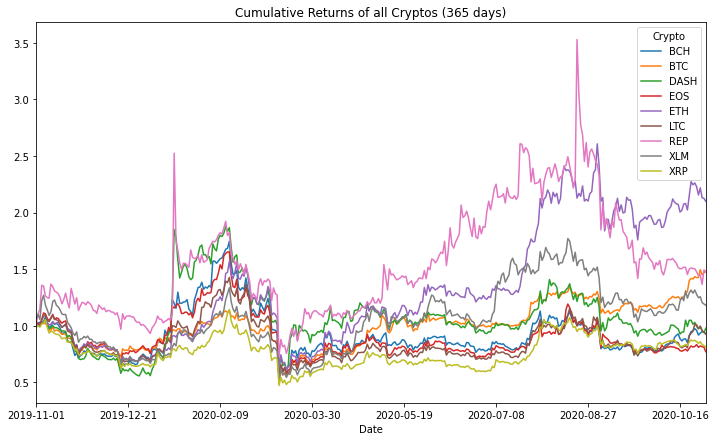

In [85]:
# Calculate cumulative returns for all cryptos

cumulative_crypto_returns.plot(figsize=(12,7), title = "Cumulative Returns of all Cryptos (365 days)")

In [86]:
# The plot shows that ETH has the highest cumulative return over the course of 365 days.

In [87]:
# Calculate daily std for all cryptos (365 trading days)

daily_crypto_std = daily_crypto_returns.std()
daily_crypto_std.sort_values(ascending=False)

Crypto
REP     0.093172
DASH    0.060815
BCH     0.053155
ETH     0.050264
EOS     0.049923
XLM     0.048446
LTC     0.048029
XRP     0.040540
BTC     0.038413
dtype: float64

In [88]:
# Calculate annual std for all cryptos (365 trading days)

annualized_crypto_std = daily_crypto_std * np.sqrt(365)
annualized_crypto_std.sort_values(ascending=False)

Crypto
REP     1.780055
DASH    1.161866
BCH     1.015527
ETH     0.960295
EOS     0.953786
XLM     0.925553
LTC     0.917598
XRP     0.774509
BTC     0.733874
dtype: float64

<AxesSubplot:title={'center':'Rolling 30-day Crypto Returns (365 Days)'}, xlabel='Date'>

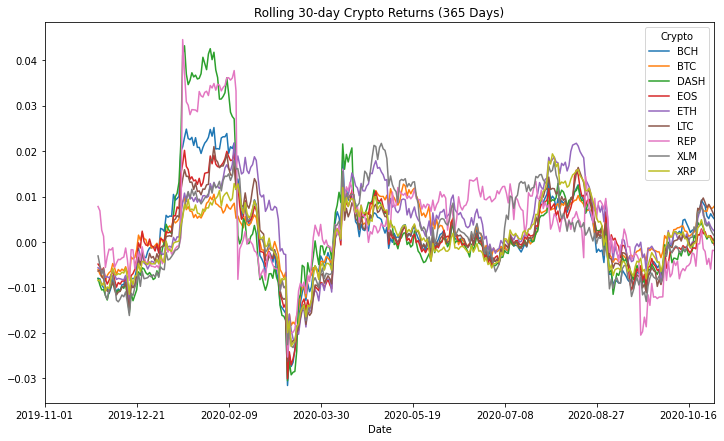

In [89]:
# Calculate rolling 30 day returns and standard deviation for all cryptos

daily_crypto_returns.rolling(window=30).mean().plot(figsize=(12,7),title="Rolling 30-day Crypto Returns (365 Days)")

<AxesSubplot:title={'center':'Rolling 30-day Crypto Standard Dev (365 Days)'}, xlabel='Date'>

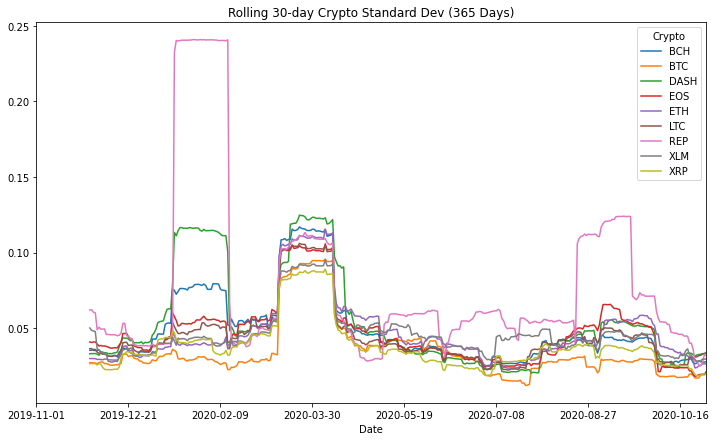

In [90]:
daily_crypto_returns.rolling(window=30).std().plot(figsize=(12,7),title="Rolling 30-day Crypto Standard Dev (365 Days)")

In [91]:
# Analysis of rolling statistics shows that REP is the most volatile of all analyzed cryptos but that excess volatility was not accompanied by higher cumulative return.

In [92]:
# Calculate return correlation between cryptos

crypto_return_corr = daily_crypto_returns.corr()
crypto_return_corr

Crypto,BCH,BTC,DASH,EOS,ETH,LTC,REP,XLM,XRP
Crypto,,,,,,,,,
BCH,1.000000,0.850447,0.677456,0.882149,0.856557,0.899879,0.342574,0.741896,0.842888
BTC,0.850447,1.000000,0.651567,0.844615,0.875291,0.872958,0.359941,0.740306,0.827476
DASH,0.677456,0.651567,1.000000,0.672970,0.673827,0.684712,0.607587,0.609973,0.655242
EOS,0.882149,0.844615,0.672970,1.000000,0.858113,0.898908,0.362780,0.782894,0.843443
ETH,0.856557,0.875291,0.673827,0.858113,1.000000,0.897929,0.368129,0.797309,0.882174
LTC,0.899879,0.872958,0.684712,0.898908,0.897929,1.000000,0.361961,0.787956,0.870957
REP,0.342574,0.359941,0.607587,0.362780,0.368129,0.361961,1.000000,0.390350,0.355645
XLM,0.741896,0.740306,0.609973,0.782894,0.797309,0.787956,0.390350,1.000000,0.831115
XRP,0.842888,0.827476,0.655242,0.843443,0.882174,0.870957,0.355645,0.831115,1.000000


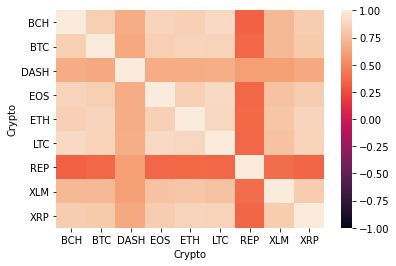

In [93]:
crypto_corr_plot = sns.heatmap(crypto_return_corr, vmin=-1, vmax =1)

In [94]:
# The least correlated cryptos are REP and BCH, the most correlated cryptos are LTC and BCH

In [95]:
sharpe_ratios = (daily_crypto_returns.mean() * 365) / annualized_crypto_std

sharpe_ratios.sort_values(ascending=False)

Crypto
ETH     1.287688
BTC     0.935241
REP     0.914407
XLM     0.653579
DASH    0.543343
BCH     0.464925
LTC     0.396564
EOS     0.235823
XRP     0.137951
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}, xlabel='Crypto'>

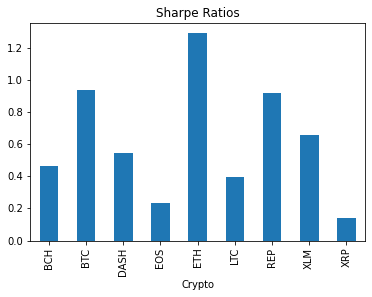

In [96]:
sharpe_ratios.plot(kind="bar",title="Sharpe Ratios")

In [97]:
# Sharpe ratio analysis shows that investing in ETH over the course of last 365 days would have achieved the highest risk adjusted return.

In [98]:
# Cumulative returns of four main cryptos

main_cryptos_cum_ret = cumulative_crypto_returns[["BTC","ETH","REP","XLM"]]
main_cryptos_cum_ret.head()

Crypto,BTC,ETH,REP,XLM
Date,,,,
2019-11-01,1.010223,1.004441,1.012209,1.063210
2019-11-02,1.016272,1.004770,1.106548,1.098740
2019-11-03,1.005136,0.996436,1.143174,1.055253
2019-11-04,1.027627,1.021219,1.357381,1.221137
2019-11-05,1.017753,1.035640,1.350721,1.269002


<AxesSubplot:title={'center':'Cumulative Returns of BTC, ETH, REP, XLM (365 days)'}, xlabel='Date'>

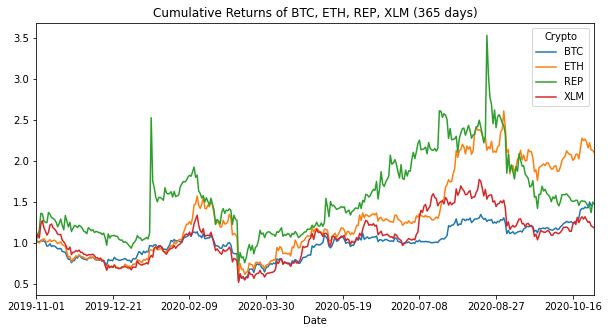

In [99]:
main_cryptos_cum_ret.plot(figsize=(10,5), title = "Cumulative Returns of BTC, ETH, REP, XLM (365 days)")

In [100]:
# Correlation of four main cryptos to others 

main_cryptos_corr = crypto_return_corr[["BTC","ETH","REP","XLM"]]
main_cryptos_corr

Crypto,BTC,ETH,REP,XLM
Crypto,,,,
BCH,0.850447,0.856557,0.342574,0.741896
BTC,1.000000,0.875291,0.359941,0.740306
DASH,0.651567,0.673827,0.607587,0.609973
EOS,0.844615,0.858113,0.362780,0.782894
ETH,0.875291,1.000000,0.368129,0.797309
LTC,0.872958,0.897929,0.361961,0.787956
REP,0.359941,0.368129,1.000000,0.390350
XLM,0.740306,0.797309,0.390350,1.000000
XRP,0.827476,0.882174,0.355645,0.831115


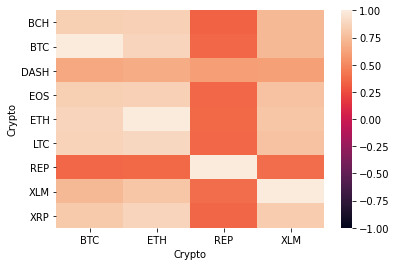

In [101]:
# Correlation of four main cryptos to all others. It appears that REP has a high level of correlation to all others where others show lower level of correlation to others except DASH.

main_cryptos_corr.plot = sns.heatmap(main_cryptos_corr, vmin=-1, vmax =1)

<AxesSubplot:title={'center':'Rolling 30-day Returns BTC, ETH, REP, BCH, XLM (365 Days)'}, xlabel='Date'>

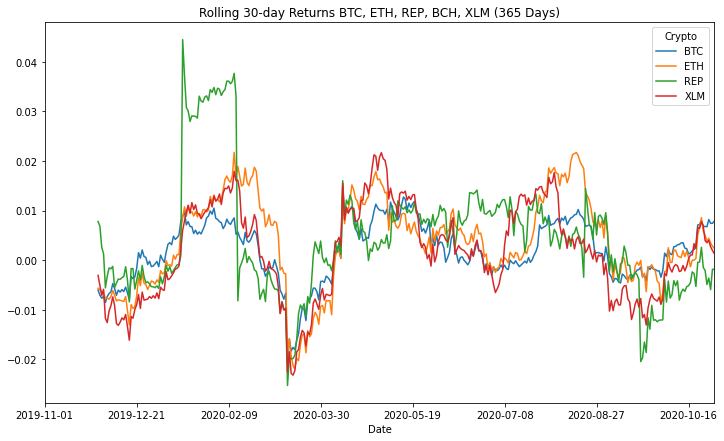

In [102]:
# Rolling 30-day returns of four main cryptos

daily_crypto_returns[["BTC","ETH","REP","XLM"]].rolling(window=30).mean().plot(figsize=(12,7),title="Rolling 30-day Returns BTC, ETH, REP, BCH, XLM (365 Days)")

<AxesSubplot:title={'center':'Rolling 30-day Std Dev BTC, ETH, REP, BCH, XLM (365 Days)'}, xlabel='Date'>

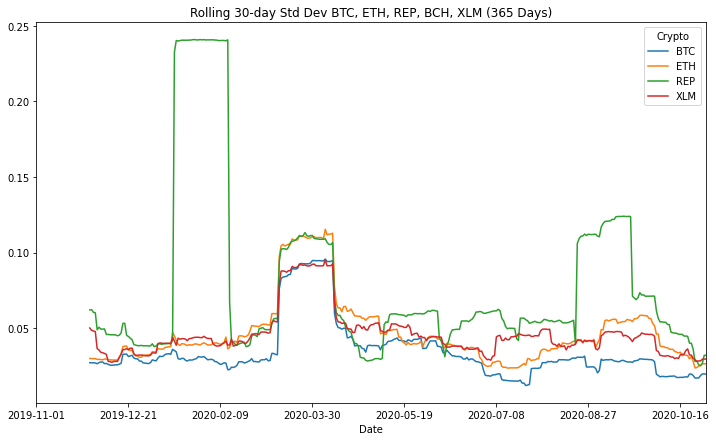

In [103]:
# Rolling standard deviation of four main cryptos

daily_crypto_returns[["BTC","ETH","REP","XLM"]].rolling(window=30).std().plot(figsize=(12,7),title="Rolling 30-day Std Dev BTC, ETH, REP, BCH, XLM (365 Days)")

In [104]:
# Sharpe rations of four main cryptos

main_four_sharpe = sharpe_ratios[["BTC", "ETH", "REP", "XLM"]].sort_values(ascending=False)



<AxesSubplot:title={'center':'Sharpe Ratios'}, xlabel='Crypto'>

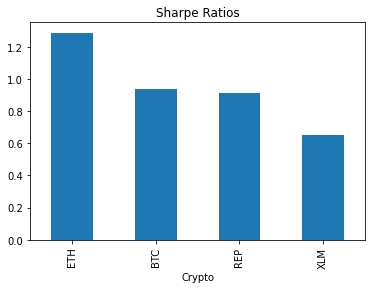

In [105]:
main_four_sharpe.plot(kind="bar",title="Sharpe Ratios")